<a href="https://colab.research.google.com/github/bushragit/MLP/blob/main/AgenticRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qU langchain-groq langchain_core "langchain-chroma>=0.1.2"  langchain_community  sentence_transformers  fastembed lark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 84.7 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
userdata.get('groq_api_key')
import os
os.environ["GROQ_API_KEY"]=userdata.get('groq_api_key')


In [ ]:
# import getpass
# import os
# os.environ["GROQ_API_KEY"]=getpass.getpass("enter you're API key")

In [4]:
from langchain_groq import ChatGroq
from langchain_chroma import Chroma
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.embeddings.base import Embeddings
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from langchain_community.document_loaders import WebBaseLoader
import bs4

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
model = ChatGroq(model="mixtral-8x7b-32768",
                max_tokens=None,
                timeout=None,
                max_retries=2)

In [6]:
from langchain_community.document_loaders import WebBaseLoader
import bs4

In [7]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

In [8]:
docs =loader.load()

In [9]:
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [10]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200 )

In [11]:
splits=text_splitter.split_documents(docs)

In [12]:
splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

In [13]:
# text = '''Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='The AI assistant can parse user input to several tasks: [{"task": task, "id", task_id, "dep": dependency_task_ids, "args": {"text": text, "image": URL, "audio": URL, "video": URL}}]. The "dep" field denotes the id of the previous task which generates a new resource that the current task relies on. A special tag "-task_id" refers to the generated text image, audio and video in the dependency task with id as task_id. The task MUST be selected from the following options: {{ Available Task List }}. There is a logical relationship between tasks, please note their order. If the user input can\'t be parsed, you need to reply empty JSON. Here are several cases for your reference: {{ Demonstrations }}. The chat history is recorded as {{ Chat History }}. From this chat history, you can find the path of the user-mentioned resources for your task planning.'),'''
# for i in text:
#     count+=1
# print(count)

In [14]:
len(splits)
type(splits) #splits is an array element of same type

list

In [15]:
splits[3].page_content

'Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'

In [16]:
embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-base-en-v1.5")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/218M [00:00<?, ?B/s]

In [17]:
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)

In [18]:
retriever = vectorstore.as_retriever()

So the process is:

User query -> Convert query into a vector.
Retrieve the most similar vectors from the vector store (based on similarity).
Return the original text chunks (from the splits) that correspond to those similar vectors.
In summary:

Yes, the split text is first converted into vectors, then the query is converted into a vector, and the retriever finds the most similar vectors. The text related to the closest vectors is returned. The retriever doesn't need to convert vectors back to text—it's the text that was originally associated with the vectors that gets retrieved.

In [19]:
#import prompt hub
from langchain import hub

In [21]:
from google.colab import userdata
userdata.get('langchain')


'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'

In [22]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = userdata.get('langchain')

In [23]:
prompt = hub.pull("rlm/rag-prompt")
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [24]:
def format_docs(docs):    #joint chunks after retrive of document use when form chain
    return "\n\n".join(doc.page_content for doc in docs)

In [25]:
rag_chain = (
    {"context":retriever |format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

Full Flow:  
Retriever: Finds relevant chunks of text from the vector store based on the question.  
Format Docs: Formats the retrieved documents for the model.  
Prompt: Combines the formatted context with the original question using a template.  
Model: The language model processes both the context and the question to generate an answer.  
StrOutputParser: Formats the model’s output into the final string response.

In [26]:
retriever.invoke("what is the main character")  #retreiver do that

[Document(id='5707fb18-973a-4fe8-a7b9-924c76998b4a', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='},\n  {\n    "role": "user",\n    "content": "{{There are 10 levels in total. The main character is a plumber named Mario, who can walk and jump. It is a classical platform game just like Super Mario. The main character moves from left to right, trying to get to the destination, where there are many obstacles and attacks from enemies in the process.}}\\n\\nIs anything else unclear? If yes, only answer in the form:\\n{remaining unclear areas} remaining questions.\\n{Next question}\\nIf everything is sufficiently clear, only answer \\"Nothing more to clarify.\\"."\n  },\n  {\n    "role": "assistant",\n    "content": "Remaining unclear areas: 2 remaining questions.\\nCan you provide more information about how the MVC components are split into separate files?"\n  },\n  {\n    "role": "user",\n    "content": "{{Make your own assumptions and state th

In [27]:
rag_chain.invoke("what is the main character")  #LLM do that


'The main character of the game is Mario, a plumber who is the primary focus of the game.'

In [28]:
#vectorstore of different collection
vectorstore = Chroma.from_documents(
    documents=splits,
    collection_name="rag-private",
    embedding= embeddings,
)

In [29]:
QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from
    a vector database. By generating multiple perspectives on the user question, your
    goal is to help the user overcome some of the limitations of the distance-based
    similarity search. Provide these alternative questions separated by newlines.
    Original question: {question}""",
)

In [30]:
#now use multiquery retriever as retriever it create five variants of questions based on user question as user might not question properly
retriever = MultiQueryRetriever.from_llm(
    vectorstore.as_retriever(),
    llm=model,
    prompt=QUERY_PROMPT
)


In [31]:
#What's happening in background like error log in webservers, logging whatever multiquery do in background to see from logging_warning to login_info
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [32]:
template = """Answer the question based only on the following context:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [33]:
# chain = (
#     RunnableParallel({"context": retriever, "question": RunnablePassthrough()})
#     | prompt
#     | model
#     | StrOutputParser()
# )

chain = (
    RunnableParallel({"context": retriever, "question": RunnablePassthrough()})
    | prompt
    | model
    | StrOutputParser()
)

In [34]:
response = chain.invoke("what are agent systems?")

INFO:langchain.retrievers.multi_query:Generated queries: ['1. Can you explain the concept of agent-based systems?', '2. What are the key components and functionalities of agent systems?', '3. How do agent systems work and what are their applications?', '4. What is the role of agents in distributed systems, known as agent systems?', '5. Can you provide a detailed overview of various agent systems and their features?']


In [35]:
response

"Based on the provided document, an agent system is a type of autonomous system that relies on a large language model (LLM) as its core controller. The LLM functions as the agent's brain, complemented by several key components such as planning, memory, and retrieval model. The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks. It can also do self-criticism and self-reflection over past actions, learn from mistakes, and refine them for future steps, thereby improving the quality of final results. The memory stream is a long-term memory module that records a comprehensive list of agents' experience in natural language, and the retrieval model surfaces the context to inform the agent's behavior according to relevance, recency, and importance. The reflection mechanism synthesizes memories into higher level inferences over time and guides the agent's future behavior."

### Self Query Retreiver (to answer from metadata)

In [36]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

In [37]:
loader = WebBaseLoader(["https://lilianweng.github.io/posts/2023-06-23-agent/", "https://lilianweng.github.io/posts/2024-07-07-hallucination/"])
data = loader.load()

In [38]:
for doc in data:
  print(doc.metadata)

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\

In [39]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The web url of the web page",
        type="string",
    ),
    AttributeInfo(
        name="title",
        description="The title of the web page",
        type="string",
    ),
    AttributeInfo(
        name="description",
        description="Description regarding the page contents",
        type="string",
    ),
    AttributeInfo(
        name="language", description="Langugae of the contents in abbreviated form for example en for English etc.", type="string"
    ),
]

In [40]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
all_splits = text_splitter.split_documents(data)

In [41]:
all_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [42]:
vectorstore = Chroma.from_documents(all_splits, embeddings)

In [43]:
document_conent_description = "web pages about LLMs"

In [44]:
retriever = SelfQueryRetriever.from_llm(
    model, vectorstore, document_conent_description, metadata_field_info, verbose=True
)

In [45]:
retriever.invoke("What are few of the use cases for agent systems?")

[Document(id='2f098646-1f04-4e4f-97b9-6c049d83f247', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context 

In [46]:
#chunks from vectore store isin json from

In [47]:
#also filter chunks on base on metadata after it retreive from vectorstore u can also edit metadata

In [48]:
#uu_id = universally unique (increase length)
#gu_id = globally unique (less length)

## LANGRAPH

In [49]:
!pip install langgraph
!pip install langchain-groq
!pip install langchain langchain_core langchain_community fastembed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.9 MB/s eta 0:00:00


In [50]:
def function_1(input_1):
    return input_1 + " First Function"

def function_2(input_2):
    return input_2 + " to Second Function"

def function_3(input_3):
    return input_3 + " to Third Function"

In [51]:
from langgraph.graph import Graph
workflow = Graph()
workflow.add_node("node_1", function_1) #when node1 call execute function_1
workflow.add_node("node_2", function_2)
workflow.add_node("node_3", function_3)
#connection b/w two nodes is edge
workflow.add_edge("node_1", "node_2") #information flow from node 1 to node 2 (direction is important)
workflow.add_edge("node_2", "node_3")
workflow.set_entry_point("node_1")
workflow.set_finish_point("node_3")

app = workflow.compile()

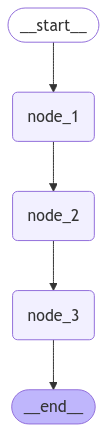

In [52]:
#if you want to display a graph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [53]:
#if want to execute workflow
app.invoke("starting from ")  #output isof sencond function

'starting from  First Function to Second Function to Third Function'

In [54]:
input = 'Moving from'   #in streamimg you can see what you send first then what in second then soon until complete
for output in app.stream(input):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'node_1':
---
Moving from First Function

---

Output from node 'node_2':
---
Moving from First Function to Second Function

---

Output from node 'node_3':
---
Moving from First Function to Second Function to Third Function

---



### link language model with a graph

In [55]:
llm = ChatGroq(model="mixtral-8x7b-32768",
                max_tokens=None,
                timeout=None,
                max_retries=2)

In [56]:
# def function_1(input_1):
#     complete_query = "You're task is to provide only the topic based on user query.\
#     only ouput the topic among: [Finance,Legal]. Do not include reasoning. following is the user query: " + input_1
#     response = llm.invoke(complete_query)
#     return response

# def fuction_2(input_2):
#     topic = f"Here is the topic: {input_2}"
#     return topic



In [57]:
def function_1(input_1):
  complete_query = "Your task is to provide only the topic based on the user query.\
  Only output the topic among: [Finance,Legal]. Do not include reasoning. Following is the user query: " + input_1
  response = llm.invoke(complete_query)
  return response

def function_2(input_2):
  topic = f"Here is the topic :{input_2}"
  return topic

In [58]:
from langgraph.graph import Graph
workflow = Graph()
workflow.add_node("node_1", function_1) #when node1 call execute function_1
workflow.add_node("node_2", function_2)

#connection b/w two nodes is edge
workflow.add_edge("node_1", "node_2") #information flow from node 1 to node 2 (direction is important)

workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

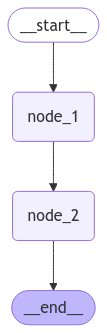

In [59]:
#if you want to display a graph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [60]:
app.invoke("The finanical report of google this year showed massive revenue generation")

"Here is the topic :content='Finance' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 59, 'total_tokens': 61, 'completion_time': 0.001566185, 'prompt_time': 0.004741654, 'queue_time': 0.13380163099999998, 'total_time': 0.006307839}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'stop', 'logprobs': None} id='run-ccc4ce96-0328-470c-b368-cb7ccdef5b75-0' usage_metadata={'input_tokens': 59, 'output_tokens': 2, 'total_tokens': 61}"

#  RAG with the Agents

### implement RAG pipeline

In [61]:
!pip install "langchain-chroma>=0.1.2"

In [62]:
from langchain_community.document_loaders import WebBaseLoader
import bs4 #bs4 for formatting

In [63]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

In [64]:
docs = loader.load()

In [65]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)


In [66]:
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]  #i.page_content for i in new_docs

In [67]:
embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-base-en-v1.5")

In [68]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

In [69]:
from langchain.chains import RetrievalQA

In [70]:
# input = {"messages":["tell me about agents"]} this is the state

In [71]:
# #for understanding of dictionary
# State = {}
# State["messages"]=["L"]
# print(State["messages"][-1])
# print(State["messages"][0])
# State["messages"].append("Agent")
# State
# State["messages"]
# print({State["messages"]:State["messages"][-1]})

In [73]:
def function1(state): #inputs= {"messages":["tell me about agents"]}
    messages=state["messages"]  # ["tell me about agents"]
    question=messages[-1]       # "tell me about agents"

    complete_query = "Your task is to provide only the topic based on the user query.\
    Only output the topic among: [Agent, Sports, Not related]. Do not include reasoning. Following is the user query: " + question
    response=llm.invoke(complete_query)
    {state["messages"].append(response.content)} #"AGENT"
    return state          #{"messages":["tell me about agents","response"]}

def function2(state):    #for RAG Call
    messages=state["messages"]  #["tell me about agents","response"]
    question=messages[0]        #"tell me about agents"

    template = """Answer the question based only on the following context:
    {context}
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    chain = (
    RunnableParallel({"context": retriever, "question": RunnablePassthrough()})
    | prompt
    | model
    | StrOutputParser()
    )

    result=chain.invoke(question)
    return {"messages":[result]}
    #return result

def function3(state):    #for LLM Call
    messages=state["messages"]
    question=messages[0]
    query="Answer the following question with you're knowlwdge of real world. Do not include reasoning\
    following is the question: "+ question
    response = llm.invoke(query)
    #print(response.content)
    return {"messages":[response.content]}

def router(state):
    messages=state["messages"]
    last_message=messages[-1]
    print(last_message)
    if "Agent" in last_message: #or "Sports":
        return "RAG Call"
    else:
        return "LLM Call"



## Graph

In [74]:
AgentState = {}
AgentState["messages"] = []

In [75]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


In [76]:
from langgraph.graph import Graph, StateGraph, END

graph = StateGraph(AgentState)
graph.add_node("agent",function1)
graph.add_node("RAG",function2)
graph.add_node("LLM",function3)

graph.set_entry_point("agent")

graph.add_conditional_edges(
    "agent",
    router,
    {
        "RAG Call" : "RAG",
        "LLM Call" :  "LLM"
    }
)

graph.add_edge("RAG",END)
graph.add_edge("LLM",END)



app=graph.compile()

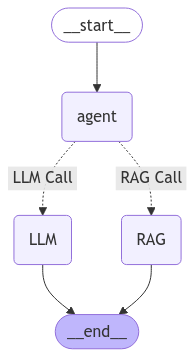

In [77]:
#if you want to display a graph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

here first function do classification and second run Rag

In [78]:
inputs= {"messages":["what is cricket"]}
app.invoke(inputs)

Sports


{'messages': ['what is cricket',
  'Sports',
  'what is cricket',
  'Sports',
  "Cricket is a popular bat-and-ball sport played between two teams, each consisting of eleven players. The game is played on a grass field with a rectangular 22-yard-long pitch at the center. One team bats and tries to score runs while the other team bowls and fields, aiming to limit the opposing team's runs and get them out. The game originated in southeast England during the 16th century and has since become a global pastime, particularly in countries such as India, Pakistan, Australia, England, South Africa, and the West Indies. Cricket matches can be played in various formats, including Test matches, One Day Internationals (ODIs), and Twenty20 (T20) matches."]}